In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmath as c
import pandas as pd
from pylab import *
from scipy.integrate import odeint
from scipy import spatial
from brokenaxes import brokenaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.offsetbox import AnchoredText

In [3]:
## Note that pandas automatically outputs a dataframe a la R,
## only no slicing indexing allowed.  To do that, you must coerce
## to an array.

#data_url = 'https://raw.githubusercontent.com/alexbbrummer/car_T/master/cart_dex_mean_sd_gbm_single_line.csv'
pbt_1_2_data_url = "../data/pbt_second_round/car_T_dex_pbt1_pbt2_lines.csv"
pbt_3_4_data_url = "../data/pbt_second_round/car_T_dex_pbt3_pbt4_lines.csv"

pbt_full_fits_url = "../car_T_notebooks/third_round_exports/pbt_1_2_4_fit_report_file_expdex_timeshift.csv"


pbt_1_2_data = pd.read_csv(pbt_1_2_data_url)
pbt_3_4_data = pd.read_csv(pbt_3_4_data_url)
pbt_full_fits = pd.read_csv(pbt_full_fits_url)

In [4]:
def lambda_d1(t,params):
    rho = params[0]
    kappa = 1/params[1]
    c0 = params[2]
    kappa1 = params[3]
    kappa2 = params[4]
    theta = params[5]
    c1 = params[6]
    t_start = params[7]
    lam = np.log(2)/3.33
    return (rho-c0*np.exp(-lam*(t-25)))

def lambda_d2(t, params):
    rho = params[0]
    kappa = 1/params[1]
    c0 = params[2]
    kappa1 = params[3]
    kappa2 = params[4]
    theta = params[5]
    c1 = params[6]
    t_start = params[7]
    lam = np.log(2)/3.33
    return (-theta-c1*np.exp(-lam*(t-25)))

In [5]:
def lambda_p1(t, params):
    rho = params[0]
    kappa = 1/params[1]
    c0 = params[2]
    kappa1 = params[3]
    kappa2 = params[4]
    theta = params[5]
    c1 = params[6]
    t_start = params[7]
    lam = np.log(2)/3.33
    return (-rho+c0*np.exp(-lam*(t-25)))

def lambda_p3D(t, params):
    rho = params[0]
    kappa = 1/params[1]
    c0 = params[2]
    kappa1 = params[3]
    kappa2 = params[4]
    theta = params[5]
    c1 = params[6]
    t_start = params[7]
    lam = np.log(2)/3.33
    A = np.array([[-1,-1,-c0],[0, (kappa2*kappa/rho)-(theta/rho),0],[0,0,-lam/rho]])
    w,v = np.linalg.eig(A)
    
#    return ((rho-c0*np.exp(-lam*(t-25)))/rho)*kappa2*kappa-theta-c1*np.exp(-lam*(t-25))
    return w,v

In [6]:
def lambdacoex2D(t, params):
#    rho = params['rho_val']
#    kappa = params['kappainv_val']
#    c0 = params['c0_val']
#    kappa1 = params['kappac1_val']
#    kappa2 = params['kappac2_val']
#    theta = params['theta_val']
#    c1 = params['c3_val']
#    t_start = params['t_start_.hr.']
    rho = params[0]
    kappa = 1/params[1]
    c0 = params[2]
    kappa1 = params[3]
    kappa2 = params[4]
    theta = params[5]
    c1 = params[6]
    t_start = params[7]
    lam = np.log(2)/3.33
#    z = (rho*(theta+c1*np.exp(-lam*(t-t_start))/(2*kappa2*kappa)))*(-1 + c.sqrt(1 + (4*kappa2*kappa/rho)*(1-(kappa2*kappa*(rho-c0*np.exp(-lam*(t-t_start))))/(rho*(theta+c1*np.exp(-lam*(t-t_start)))))))   
#    return z.real, z.imag

    A = np.array([[-rho*(theta+c1*np.exp(-lam*(t-t_start)))/(kappa2*kappa), 
                   -kappa1*(theta+c1*np.exp(-lam*(t-t_start)))/kappa2],
                  [(kappa2*(rho-c0*np.exp(-lam*(t-t_start)))/kappa1)-(rho*(theta+c1*np.exp(-lam*(t-t_start))))/(kappa1*kappa),
                  0]])
    w,v = np.linalg.eig(A)
    return w, v

def lambdacoex3D(t, params):
    rho = params[0]
    kappa = 1/params[1]
    c0 = params[2]
    kappa1 = params[3]
    kappa2 = params[4]
    theta = params[5]
    c1 = params[6]
    t_start = params[7]
    lam = np.log(2)/3.33
#    z = (rho*(theta+c1*np.exp(-lam*(t-t_start))/(2*kappa2*kappa)))*(-1 -c.sqrt(1 + (4*kappa2*kappa/rho)*(1-(kappa2*kappa*(rho-c0*np.exp(-lam*(t-t_start))))/(rho*(theta+c1*np.exp(-lam*(t-t_start)))))))
    A = theta/rho
    B = kappa2*kappa/rho
    lamr = lam/rho
    M = np.array([[-A/B,-A/B,-c0*A/B],[B-A,0,-c1*(1-A/B)],[0,0,-lamr]])
    w,v = np.linalg.eig(M)
    return w,v

In [7]:

def f_dt(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    x, y = xs
    rho, kappainv, c0, kappac1, kappac2, theta, c3, t_start, t_end = ps
#    rho = params[0]
#    kappa = 1/params[1]
#    c0 = params[2]
#    kappa1 = params[3]
#    kappa2 = params[4]
#    theta = params[5]
#    c1 = params[6]
#    t_start = params[7]
    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g_dt(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_dt, x0, t, args=(ps, t_start))
    return x

def ode(t, x, y, params):
    rho, kappainv, c0, kappac1, kappac2, theta, c3, t_start, t_end = params
    lam = np.log(2)/3.33
    xdot = rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y
    ydot = kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y
    return (xdot, ydot)

In [8]:
pbt_1_2_data.head()

,Time (Hour),"Y(A1,A2)","SD(A1,A2)","Y(B1,B2)","SD(B1,B2)","Y(C1,C2)","SD(C1,C2)","Y(D1,D2)","SD(D1,D2)","Y(E1,E2)",...,"Y(D11,D12)","SD(D11,D12)","Y(E11,E12)","SD(E11,E12)","Y(F11,F12)","SD(F11,F12)","Y(G11,G12)","SD(G11,G12)","Y(H11,H12)","SD(H11,H12)"
0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
1,0.004722,-0.00390,0.000566,-0.00040,0.001838,0.00015,0.000495,-0.00220,0.000707,0.00120,...,-0.00110,0.000849,0.00030,0.000424,-0.00105,0.000354,-0.00060,0.000424,-0.00035,0.001626
2,0.254722,-0.06250,0.001838,-0.03030,0.001980,-0.02180,0.004243,-0.01415,0.007000,-0.00995,...,-0.01040,0.003960,-0.00495,0.001344,-0.01575,0.006152,-0.02505,0.002051,-0.01740,0.006223
3,1.289444,0.09315,0.016476,0.10135,0.003889,0.07870,0.014142,0.06665,0.000636,0.12915,...,0.09630,0.005091,0.14485,0.000919,0.14610,0.010182,0.15320,0.004808,0.22425,0.005303
4,1.539722,0.01890,0.005798,0.06200,0.002687,0.06095,0.010960,0.06450,0.000990,0.23370,...,0.07995,0.006010,0.23830,0.004101,0.23150,0.010324,0.22515,0.007990,0.32560,0.015556


In [9]:
pbt_3_4_data

,Time (Hour),"Y(A1,A2)","SD(A1,A2)","Y(B1,B2)","SD(B1,B2)","Y(C1,C2)","SD(C1,C2)","Y(D1,D2)","SD(D1,D2)","Y(E1,E2)",...,"Y(D11,D12)","SD(D11,D12)","Y(E11,E12)","SD(E11,E12)","Y(F11,F12)","SD(F11,F12)","Y(G11,G12)","SD(G11,G12)","Y(H11,H12)","SD(H11,H12)"
0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
1,0.005000,-0.00205,0.000495,-0.00015,0.000495,-0.00305,0.000071,-0.00310,0.000283,0.00030,...,-0.00080,0.000707,-0.00015,0.002899,-0.00170,0.001838,-0.00025,0.001344,-0.00070,0.001273
2,0.255278,-0.05530,0.002970,-0.04720,0.005374,-0.03325,0.006576,-0.02675,0.005869,-0.02235,...,-0.01150,0.001414,-0.00885,0.000354,-0.02335,0.003889,-0.02990,0.001980,-0.02225,0.015203
3,1.280278,0.04435,0.000636,0.02095,0.008415,0.00550,0.011314,-0.01465,0.014779,0.01630,...,0.02630,0.001697,0.03735,0.002475,0.03680,0.001980,0.05615,0.001485,0.10745,0.019728
4,1.530833,-0.03295,0.000495,-0.02390,0.007920,-0.01510,0.007212,-0.01515,0.018738,0.00110,...,0.01510,0.000283,0.02770,0.000707,0.01535,0.001626,0.01270,0.002263,0.03400,0.023759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,167.016944,0.94910,0.007495,-0.20965,0.002616,-0.15365,0.025951,0.09330,0.073398,-0.07115,...,0.44040,0.101682,1.11770,0.539522,-0.10100,0.032103,-0.12635,0.024112,3.03335,0.104015
662,167.266944,0.95785,0.014071,-0.20985,0.003041,-0.15275,0.024819,0.09460,0.074105,-0.07050,...,0.44275,0.104440,1.11595,0.541856,-0.10030,0.031961,-0.12710,0.022769,3.04135,0.107975
663,167.516389,0.96005,0.017324,-0.20960,0.003677,-0.15330,0.026587,0.09075,0.069367,-0.07115,...,0.44225,0.107268,1.11610,0.538957,-0.10085,0.031466,-0.12780,0.021637,3.04960,0.128552
664,167.767500,0.96740,0.023193,-0.21055,0.002051,-0.15280,0.025597,0.09055,0.065973,-0.07140,...,0.44605,0.104864,1.11740,0.541361,-0.10185,0.031325,-0.12710,0.022345,3.06165,0.136684


In [10]:
pbt_full_fits.head()

,tumor_line,data_column,t_start_.hr.,t_end_.hr.,dex_.ug.ml.,t_cell_start.ci.,t_cell_end.ci.,chi_sq,red_chi_sq,rho_val,...,c3_val,c3_stderr,Unnamed: 23,A col,B col,B-A col,A/B col,theta/kappac2,(theta+c3)/kappa2,Kkappa2-theta
0,PBT1,"Y(A1,A2)",105,487,0.000000e+00,0.000,0.00000,174.526717,0.459281,0.045478,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PBT1,"Y(B1,B2)",100,440,0.000000e+00,0.250,0.65980,77.758586,0.141895,0.302972,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PBT1,"Y(C1,C2)",100,652,0.000000e+00,0.125,0.41550,0.562691,0.001027,0.230304,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PBT1,"Y(D1,D2)",100,652,0.000000e+00,0.050,0.33095,1.248511,0.002278,0.158647,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PBT1,"Y(A3,A4)",110,450,1.000000e-10,0.000,0.00000,971.158110,2.881775,0.035115,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Anlysis of PBT128+ with medium CAR-T concentration and Dex. 1e-07

In [30]:
## Here is code to access parameter fits given a row of choice.
# row of choice precedes lambda function call
model_params = pbt_full_fits.loc[42, lambda pbt_full_fits: ['tumor_line', 't_cell_start.ci.', 'dex_.ug.ml.','rho_val','kappainv_val','c0_val',
                                       'kappac1_val','kappac2_val','theta_val',
                                       'c3_val', 't_start_.hr.', 't_end_.hr.']]
print(model_params)
### CAUTION  t_start_.hr. and t_end_.hr. are row indeces for the raw data, not values, next two lines convert
model_params['t_start_.hr.'] =  pbt_1_2_data.loc[model_params['t_start_.hr.'],'Time (Hour)']
model_params['t_end_.hr.'] =  pbt_1_2_data.loc[model_params['t_end_.hr.']-1,'Time (Hour)']
pbt_full_fits.loc[pbt_full_fits['tumor_line'] == 'PBT2',:]

tumor_line              PBT2
t_cell_start.ci.       0.125
dex_.ug.ml.         0.000001
rho_val             0.178568
kappainv_val        0.141216
c0_val             -0.150164
kappac1_val         0.549594
kappac2_val         0.003861
theta_val           0.013713
c3_val             -0.126723
t_start_.hr.             120
t_end_.hr.               652
Name: 42, dtype: object


,tumor_line,data_column,t_start_.hr.,t_end_.hr.,dex_.ug.ml.,t_cell_start.ci.,t_cell_end.ci.,chi_sq,red_chi_sq,rho_val,...,c3_val,c3_stderr,Unnamed: 23,A col,B col,B-A col,A/B col,theta/kappac2,(theta+c3)/kappa2,Kkappa2-theta
24,PBT2,"Y(H1,H2)",115,250,0.000000e+00,0.000,0.00000,42.233883,0.317548,0.109995,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,PBT2,"Y(G1,G2)",125,345,0.000000e+00,0.250,0.55800,6847.952953,13.093600,0.470864,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,PBT2,"Y(F1,F2)",125,652,0.000000e+00,0.125,0.32060,3.051664,0.005835,0.358709,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,PBT2,"Y(E1,E2)",125,652,0.000000e+00,0.050,0.21640,9.493928,0.018153,0.228900,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,PBT2,"Y(H3,H4)",115,275,1.000000e-10,0.000,0.00000,8218.601545,52.347781,0.163096,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,PBT2,"Y(H5,H6)",115,275,1.000000e-09,0.000,0.00000,3.445824,0.021948,0.181623,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,PBT2,"Y(H7,H8)",115,275,1.000000e-08,0.000,0.00000,7.547356,0.048072,0.179687,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,PBT2,"Y(H9,H10)",115,275,1.000000e-07,0.000,0.00000,4.573128,0.029128,0.184510,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,PBT2,"Y(H11,H12)",115,275,1.000000e-06,0.000,0.00000,67.868779,0.432285,0.187257,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,PBT2,"Y(G3,G4)",120,370,1.000000e-10,0.250,0.60505,20649.347030,39.108612,0.163096,...,-0.217303,0.025298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
## Viewing identifying information for row of interest

for i in range(0,48):
    
    model_params = pbt_full_fits.loc[i, lambda pbt_full_fits: ['rho_val','kappainv_val','c0_val',
                                       'kappac1_val','kappac2_val','theta_val',
                                       'c3_val', 't_start_.hr.', 't_end_.hr.']]
    model_params['t_start_.hr.'] =  pbt_1_2_data.loc[model_params['t_start_.hr.'],'Time (Hour)']
    model_params['t_end_.hr.'] =  pbt_1_2_data.loc[model_params['t_end_.hr.']-1,'Time (Hour)']
#print(pbt_full_fits.loc[41, lambda pbt_full_fits: ['tumor_line', 'dex_.ug.ml.', 't_cell_start.ci.', 'rho_val','kappainv_val','c0_val',
#                                       'kappac1_val','kappac2_val','theta_val',
#                                       'c3_val', 't_start_.hr.', 't_end_.hr.']])

    if model_params['kappac1_val'] != 0:
        print(i)
        print(pbt_full_fits.loc[i, lambda pbt_full_fits: ['tumor_line', 'dex_.ug.ml.', 't_cell_start.ci.']])
#        print("lambda_pers3D = " + str(lambda_p3D(model_params['t_start_.hr.'], model_params)))
#        print("lambda_coex3D = " + str(lambdacoex3D(model_params['t_start_.hr.'], model_params)))
#        print("lambda_coex3D = " + str(lambdacoex3D(model_params['t_end_.hr.'], model_params)))
#        print("lambda_death2 = " + str(lambda_d2(model_params['t_end_.hr.'], model_params)))
        print("lambda_coex2D t_start = " +str(lambdacoex2D(model_params['t_start_.hr.'], model_params)))
        #print("lambda_minus t_start = " +str(lambdaminus(model_params['t_start_.hr.'], model_params)))
        print("lambda_coex2D t_end = " +str(lambdacoex2D(model_params['t_end_.hr.'], model_params)))
        #print("lambda_minus t_end = " +str(lambdaminus(model_params['t_end_.hr.'], model_params)))

for i in range(48,pbt_full_fits.shape[0]):
    
    model_params = pbt_full_fits.loc[i, lambda pbt_full_fits: ['rho_val','kappainv_val','c0_val',
                                       'kappac1_val','kappac2_val','theta_val',
                                       'c3_val', 't_start_.hr.', 't_end_.hr.']]
    #print(model_params)
    model_params['t_start_.hr.'] =  pbt_3_4_data.loc[model_params['t_start_.hr.'],'Time (Hour)']
    if model_params['t_end_.hr.'] > 665:
        model_params['t_end_.hr.'] =  pbt_3_4_data.loc[665,'Time (Hour)']  
    else:
        model_params['t_end_.hr.'] =  pbt_3_4_data.loc[model_params['t_end_.hr.']-1,'Time (Hour)']
#print(pbt_full_fits.loc[41, lambda pbt_full_fits: ['tumor_line', 'dex_.ug.ml.', 't_cell_start.ci.', 'rho_val','kappainv_val','c0_val',
#                                       'kappac1_val','kappac2_val','theta_val',
#                                       'c3_val', 't_start_.hr.', 't_end_.hr.']])
    if model_params['kappac1_val'] != 0:
        print(i)
        print(pbt_full_fits.loc[i, lambda pbt_full_fits: ['tumor_line', 'dex_.ug.ml.', 't_cell_start.ci.']])
#        print("lambda_pers3D = " + str(lambda_p3D(model_params['t_start_.hr.'], model_params)))
#        print("lambda_coex3D = " + str(lambdacoex3D(model_params['t_start_.hr.'], model_params)))
#        print("lambda_death2 = " + str(lambda_d2(model_params['t_end_.hr.'], model_params)))
        print("lambda_coex2D t_start = " +str(lambdacoex2D(model_params['t_start_.hr.'], model_params)))
        #print("lambda_minus t_start = " +str(lambdaminus(model_params['t_start_.hr.'], model_params)))
        print("lambda_coex2D t_end = " +str(lambdacoex2D(model_params['t_end_.hr.'], model_params)))
        #print("lambda_minus t_end = " +str(lambdaminus(model_params['t_end_.hr.'], model_params)))

1
tumor_line          PBT1
dex_.ug.ml.          0.0
t_cell_start.ci.    0.25
Name: 1, dtype: object
lambda_coex2D t_start = (array([-1.73838376e-13+1.61417466e-07j, -1.73838376e-13-1.61417466e-07j]), array([[-1.31964337e-11+1.22535365e-05j, -1.31964337e-11-1.22535365e-05j],
       [ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00-0.00000000e+00j]]))
lambda_coex2D t_end = (array([-1.73838376e-13+1.61417466e-07j, -1.73838376e-13-1.61417466e-07j]), array([[-1.31964337e-11+1.22535365e-05j, -1.31964337e-11-1.22535365e-05j],
       [ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00-0.00000000e+00j]]))
2
tumor_line           PBT1
dex_.ug.ml.           0.0
t_cell_start.ci.    0.125
Name: 2, dtype: object
lambda_coex2D t_start = (array([-0.03195305+0.05299747j, -0.03195305-0.05299747j]), array([[ 0.9547386 +0.j        ,  0.9547386 -0.j        ],
       [-0.15358069-0.25472962j, -0.15358069+0.25472962j]]))
lambda_coex2D t_end = (array([-0.03195305+0.05299747j, -0.03195305-0.05299747j]), array([[ 

In [14]:
from matplotlib.legend_handler import HandlerBase


class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                        color=orig_handle[0], linestyle=orig_handle[1])
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                        color=orig_handle[2], linestyle=orig_handle[3])
        return [l1, l2]

rho_val         0.181623
kappainv_val    0.139602
c0_val          -0.08396
kappac1_val     0.359427
kappac2_val     0.028144
theta_val       0.004871
c3_val          0.011492
t_start_.hr.         120
t_end_.hr.           380
Name: 34, dtype: object
rho_val          0.181623
kappainv_val     0.139602
c0_val           -0.08396
kappac1_val      0.359427
kappac2_val      0.028144
theta_val        0.004871
c3_val           0.011492
t_start_.hr.    31.586667
t_end_.hr.      96.361667
Name: 34, dtype: object
32.25540551127819
39.94589839097744
60.00805372932331


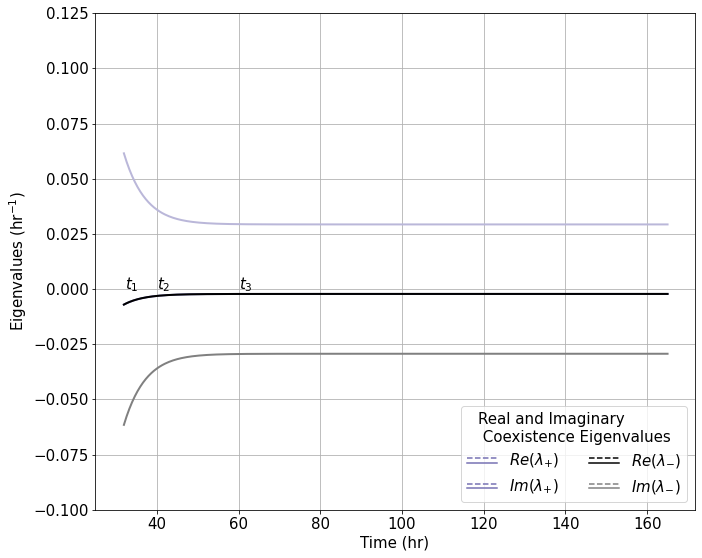

In [125]:
## Here is code to access parameter fits given a row of choice.
# row of choice precedes lambda function call
plt.rcParams.update({'font.size': 15})

model_params = pbt_full_fits.loc[34, lambda pbt_full_fits: ['rho_val','kappainv_val','c0_val',
                                       'kappac1_val','kappac2_val','theta_val',
                                       'c3_val', 't_start_.hr.', 't_end_.hr.']]
print(model_params)
### CAUTION  t_start_.hr. and t_end_.hr. are row indeces for the raw data, not values, next two lines convert
model_params['t_start_.hr.'] =  pbt_1_2_data.loc[model_params['t_start_.hr.'],'Time (Hour)']
if model_params['t_end_.hr.'] > 665:
    model_params['t_end_.hr.'] = 665
else:
    model_params['t_end_.hr.'] =  pbt_1_2_data.loc[model_params['t_end_.hr.']-1,'Time (Hour)']

print(model_params)

fig, ax = plt.subplots(figsize=(10, 8))

# Define time axis
t_start = model_params['t_start_.hr.']
#t_end = model_params['t_end_.hr.']
t_end = 165
t = np.linspace(t_start, t_end, 400)

# define timepoints for streamplot association
#0,34,60,62,70,89,114
print(t[2])
print(t[25])
#print(t[160])
print(t[85])
#print(t[231])
#print(t[297])

# calculate eigenvalues and store as lists
lambdaplusreal = [lambdacoex2D(j, model_params)[0][0].real for j in t]
lambdaplusimg = [lambdacoex2D(j, model_params)[0][0].imag for j in t]

lambdaminusreal = [lambdacoex2D(j, model_params)[0][1].real for j in t]
lambdaminusimg = [lambdacoex2D(j, model_params)[0][1].imag for j in t]

## Specify unstable/stable subsections of lines
# unstable/stable transition occurs at
tran_time = np.where(np.array(lambdaminusreal) < 0.0)[0][1]

#'#1f78b4', '#a6cee3'
#'#33a02c', '#b2df8a' '#66a61e'

ax.plot(t[0:tran_time], lambdaplusreal[0:tran_time], label=r'$Re(\lambda_{+})$', 
        linestyle = 'dashed', color = '#7570b3', linewidth = 2)
ax.plot(t[0:tran_time], lambdaplusimg[0:tran_time], label=r'$Im(\lambda_{+})$',
        linestyle = 'dashed', color = '#bab7d9', linewidth = 2)
                                       
ax.plot(t[tran_time:len(t)], lambdaplusreal[tran_time:len(t)], label=r'$Re(\lambda_{+})$', 
        linestyle = 'solid', color = '#7570b3', linewidth = 2)
ax.plot(t[tran_time:len(t)], lambdaplusimg[tran_time:len(t)], label=r'$Im(\lambda_{+})$', 
        linestyle = 'solid', color = '#bab7d9', linewidth = 2)

ax.plot(t[0:tran_time], lambdaminusreal[0:tran_time], label=r'$Re(\lambda_{-})$', 
        linestyle = 'dashed', color = 'k', linewidth = 2)
ax.plot(t[0:tran_time], lambdaminusimg[0:tran_time], label=r'$Im(\lambda_{-})$', 
        linestyle = 'dashed', color = 'gray', linewidth = 2)

ax.plot(t[tran_time:len(t)], lambdaminusreal[tran_time:len(t)], label=r'$Re(\lambda_{-})$', 
        linestyle = 'solid', color = 'k', linewidth = 2)
ax.plot(t[tran_time:len(t)], lambdaminusimg[tran_time:len(t)], label=r'$Im(\lambda_{-})$', 
        linestyle = 'solid', color = 'gray', linewidth = 2)

#ax.plot(t, lambdaminusreal, label=r'$Re(\lambda_{-})$', linestyle = 'dashed', color = 'green')
#ax.plot(t, lambdaminusimg, label=r'$Im(\lambda_{-})$', linestyle = 'dashdot', color = 'red')

ax.legend([('#7570b3','dashed', '#7570b3', 'solid'), ('#7570b3','dashed', '#7570b3', 'solid'), 
           ('k', 'dashed', 'k', 'solid'), ('gray', 'dashed', 'gray', 'solid')],
          [r'$Re(\lambda_{+})$', r'$Im(\lambda_{+})$', r'$Re(\lambda_{-})$', r'$Im(\lambda_{-})$'],
          title = 'Real and Imaginary \n Coexistence Eigenvalues', ncol = 2, loc=4,
         handler_map = {tuple: AnyObjectHandler()})
ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'Eigenvalues (hr$^{-1}$)')
ax.set_ylim(-0.1,0.125)
ax.grid(True)

## Adding text to indicate locations of streamplots
ax.text(t[2],0, '$t_1$')
ax.text(t[25],0, '$t_2$')
ax.text(t[85],0, '$t_3$')
#ax.text(t[182],0, '$t_4$')
#ax.text(t[231],0, '$t_5$')
#ax.text(t[297],0, '$t_6$')

plt.tight_layout()
#plt.title('Coexistence eigenvalues versus time for PBT128+ responder \n with medium CAR-T concentration and Dex. = 1e-07g/ml')

# generate inset axes ## turned off for stable scenario
#axins = inset_axes(ax, 3,2 , loc=2, bbox_to_anchor=(0.535, 0.85),
#                   bbox_transform=ax.figure.transFigure) #2nd and 3rd set zoom

# fix the x, y limit of the inset axes
#axins.set_xlim(50, 65)
#axins.set_ylim(-0.01, 0.01)

# plot in the inset axes
#axins.plot(t[0:tran_time],lambdaplusreal[0:tran_time], linestyle = 'dashed', color = '#477415',
#          linewidth = 2)
#axins.plot(t[0:tran_time],lambdaplusimg[0:tran_time], linestyle = 'dashed', color = '#b2d28e',
#          linewidth = 2)

#axins.plot(t[tran_time:len(t)],lambdaplusreal[tran_time:len(t)], linestyle = 'solid', color = '#477415',
#          linewidth = 2)
#axins.plot(t[tran_time:len(t)],lambdaplusimg[tran_time:len(t)], linestyle = 'solid', color = '#b2d28e',
#          linewidth = 2)


#axins.plot(t[0:tran_time],lambdaminusreal[0:tran_time], linestyle = 'dashed', color = 'k',
#          linewidth = 2)
#axins.plot(t[0:tran_time],lambdaminusimg[0:tran_time], linestyle = 'dashed', color = 'gray',
#          linewidth = 2)

#axins.plot(t[tran_time:len(t)],lambdaminusreal[tran_time:len(t)], linestyle = 'solid', color = 'k',
#          linewidth = 2)
#axins.plot(t[tran_time:len(t)],lambdaminusimg[tran_time:len(t)], linestyle = 'solid', color = 'gray',
#          linewidth = 2)
#axins.text(t[185],-0.01, '$t_4$')
#axins.text(t[231],-0.01, '$t_5$')
#axins.text(t[288],-0.01, '$t_6$')

#axins.grid(True)


# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.savefig('/Users/abrummer/Desktop/eigenvalues_pbt128+_carthigh_dex1e09.png', dpi = 300)

plt.show()

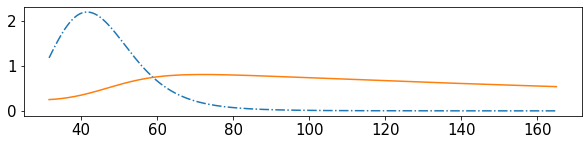

In [126]:
### streamplotting here.  redefine model_params here
model_params = pbt_full_fits.loc[34, lambda pbt_full_fits: ['tumor_line', 'data_column', 'dex_.ug.ml.', 
                                                            't_cell_start.ci.', 't_cell_end.ci.','rho_val',
                                                            'kappainv_val','c0_val','kappac1_val','kappac2_val',
                                                            'theta_val','c3_val', 't_start_.hr.', 't_end_.hr.']]
#Initialize populations from model_parameters table
tum_cell0 = pbt_1_2_data.loc[model_params['t_start_.hr.'],model_params['data_column']]
cart_cell0 = model_params['t_cell_start.ci.']

x0 = np.array([tum_cell0, cart_cell0])

t = np.linspace(t_start, t_end, 400)
#t = np.array(pbt_1_2_data.loc[model_params['t_start_.hr.']:model_params['t_end_.hr.'],'Time (Hour)'])

# Redefine model parameters to isolate only parameters used in integration
model_params = pbt_full_fits.loc[34, lambda pbt_full_fits: ['rho_val','kappainv_val','c0_val',
                                       'kappac1_val','kappac2_val','theta_val',
                                       'c3_val', 't_start_.hr.', 't_end_.hr.']]
### CAUTION  t_start_.hr. and t_end_.hr. are row indeces for the raw data, not values, next two lines convert
model_params['t_start_.hr.'] =  pbt_1_2_data.loc[model_params['t_start_.hr.'],'Time (Hour)']
model_params['t_end_.hr.'] =  pbt_1_2_data.loc[model_params['t_end_.hr.']-1,'Time (Hour)']

model_params = np.array(model_params)

# Integrate to extract CAR-T cell population with time
prediction = g_dt(t, x0, model_params)
plt.figure(figsize=(10,2))
plt.plot(t,prediction[:,0], linestyle = 'dashdot')
plt.plot(t,prediction[:,1])
plt.show()

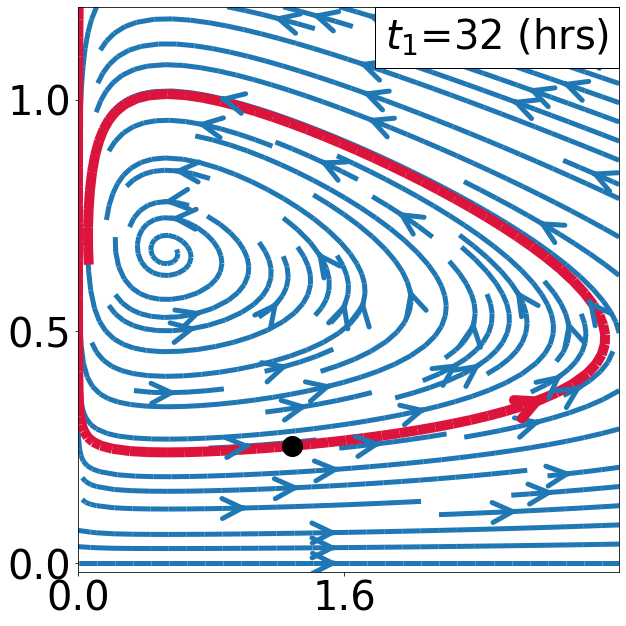

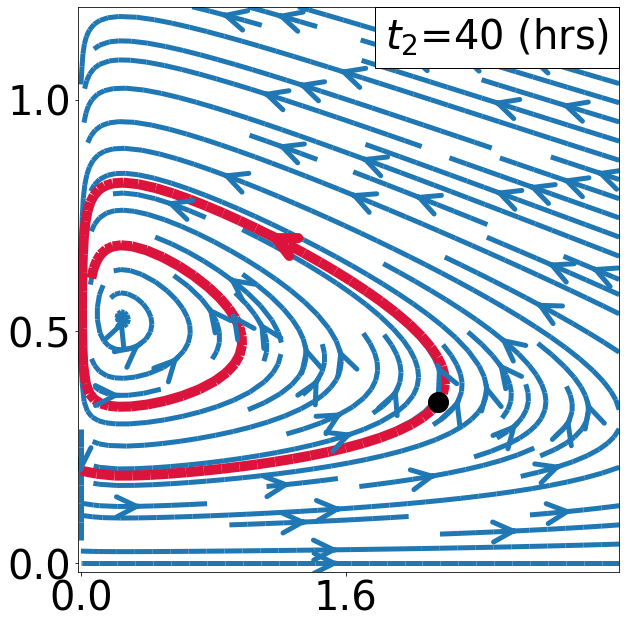

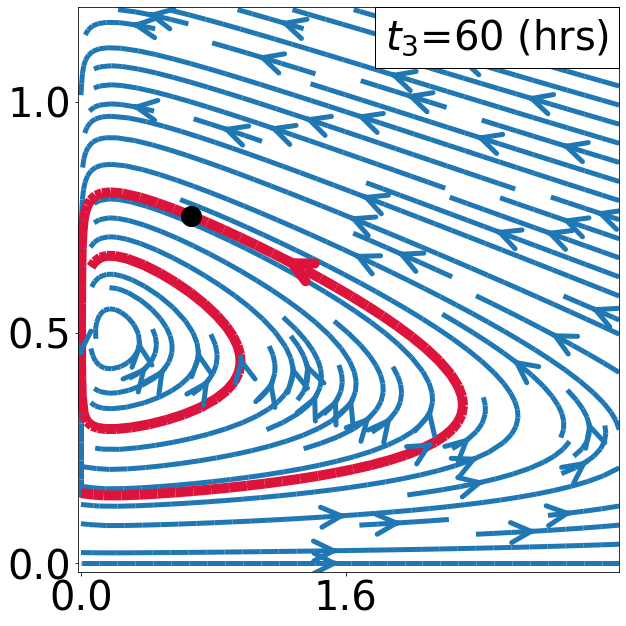

In [132]:
## Looping through values found and saving as figures.
xvalues, yvalues = meshgrid(np.linspace(0.,3.25,num = 400), np.linspace(0.,1.2, num = 400))
count = 0
subset = [1,2,3]

for i in [2,25,85]:
    plt.rcParams.update({'font.size': 50})
    xdot, ydot = ode(t[i], xvalues, yvalues, model_params)
    start = [prediction[i,:]]
#    start = [[1,0.3]]
    time = t[i]

    fig, ax = plt.subplots(figsize = (10,10))
    ax.streamplot(xvalues, yvalues, xdot, ydot, linewidth = 5,
                 arrowsize = 5, arrowstyle = '->')
    ax.streamplot(xvalues, yvalues, xdot, ydot, start_points = start, linewidth = 10,
                  color = 'crimson', arrowsize = 5, arrowstyle = '->')
    ax.plot(*start[0], marker = 'o', color = 'k', markersize = 20)
#    plt.xlabel('Tumor Cell Population (CI)')
#    plt.ylabel('CAR T-cell population (CI)')
    plt.xlabel('')
    plt.ylabel('')
#    plt.title('t = %2.2f hrs' % time, size = 40)
    anchored_text = AnchoredText(r'$t_%i$=%2.0f (hrs)' % (subset[count], time), loc = 1, 
                                 borderpad = 0, pad = 0.25, prop=dict(size=40))
    ax.add_artist(anchored_text)
    count = count+1
    ax.set_xticks([0,1.6,3.3])
    ax.set_yticks([0,0.5,1])
    ax.margins(x=0,y=0)
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)
    plt.tight_layout()


    plt.savefig('/Users/abrummer/Desktop/streamplot_pbt128+_carthigh_dex1e9_time'+str(round(time,1))+'.png', 
                dpi = 300)
    plt.show()

# Anlysis of PBT128+ with medium CAR-T concentration and Dex. 1e-09

In [133]:
## Here is code to access parameter fits given a row of choice.
# row of choice precedes lambda function call
model_params = pbt_full_fits.loc[36, lambda pbt_full_fits: ['rho_val','kappainv_val','c0_val',
                                       'kappac1_val','kappac2_val','theta_val',
                                       'c3_val', 't_start_.hr.', 't_end_.hr.']]
print(model_params)
### CAUTION  t_start_.hr. and t_end_.hr. are row indeces for the raw data, not values, next two lines convert
model_params['t_start_.hr.'] =  pbt_1_2_data.loc[model_params['t_start_.hr.'],'Time (Hour)']
model_params['t_end_.hr.'] =  pbt_1_2_data.loc[model_params['t_end_.hr.']-1,'Time (Hour)']
print(model_params)

rho_val         0.188145
kappainv_val    0.136876
c0_val         -0.162837
kappac1_val     0.489366
kappac2_val      0.01256
theta_val           0.01
c3_val         -0.056825
t_start_.hr.         120
t_end_.hr.           652
Name: 36, dtype: object
rho_val           0.188145
kappainv_val      0.136876
c0_val           -0.162837
kappac1_val       0.489366
kappac2_val        0.01256
theta_val             0.01
c3_val           -0.056825
t_start_.hr.     31.586667
t_end_.hr.      164.490556
Name: 36, dtype: object


In [134]:
print(pbt_full_fits.loc[36, lambda pbt_full_fits: ['tumor_line', 'dex_.ug.ml.', 't_cell_start.ci.', 'rho_val','kappainv_val','c0_val',
                                       'kappac1_val','kappac2_val','theta_val',
                                       'c3_val', 't_start_.hr.', 't_end_.hr.']])
print(lambdaplus(model_params['t_start_.hr.'], model_params))
print(lambdaminus(model_params['t_start_.hr.'], model_params))
print(lambdaplus(model_params['t_end_.hr.'], model_params))
print(lambdaminus(60, model_params))

tumor_line              PBT2
dex_.ug.ml.              0.0
t_cell_start.ci.        0.25
rho_val             0.188145
kappainv_val        0.136876
c0_val             -0.162837
kappac1_val         0.489366
kappac2_val          0.01256
theta_val               0.01
c3_val             -0.056825
t_start_.hr.             120
t_end_.hr.               652
Name: 36, dtype: object


NameError: name 'lambdaplus' is not defined

32.25540551127819
38.27405211278195
42.28648318045113
60.00805372932331
68.03291586466165
78.39836278947368
130.55996666917292


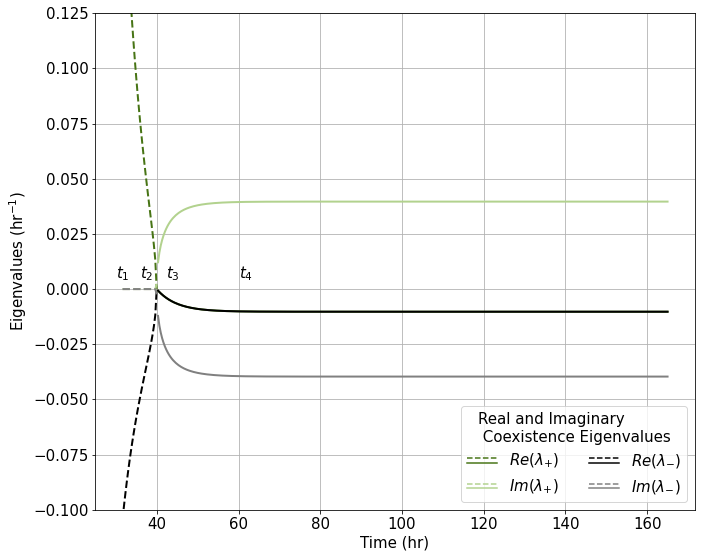

In [135]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 8))

t_start = model_params['t_start_.hr.']
t_end = 165
#t_end = model_params['t_end_.hr.']
t = np.linspace(t_start, t_end, 400)

print(t[2])
print(t[20])
print(t[32])
print(t[85])
print(t[109])
print(t[140])
print(t[296])

# calculate eigenvalues and store as lists
lambdaplusreal = [lambdacoex2D(j, model_params)[0][0].real for j in t]
lambdaplusimg = [lambdacoex2D(j, model_params)[0][0].imag for j in t]

lambdaminusreal = [lambdacoex2D(j, model_params)[0][1].real for j in t]
lambdaminusimg = [lambdacoex2D(j, model_params)[0][1].imag for j in t]

## Specify unstable/stable subsections of lines
# unstable/stable transition occurs at
tran_time = np.where(np.array(lambdaplusreal) < 0.0)[0][1]

ax.plot(t[0:tran_time], lambdaplusreal[0:tran_time], label=r'$Re(\lambda_{+})$', 
        linestyle = 'dashed', color = '#477415', linewidth = 2)
ax.plot(t[0:tran_time], lambdaplusimg[0:tran_time], label=r'$Im(\lambda_{+})$', 
        linestyle = 'dashed', color = '#b2d28e', linewidth = 2)
                                       
ax.plot(t[tran_time:len(t)], lambdaplusreal[tran_time:len(t)], label=r'$Re(\lambda_{+})$', 
        linestyle = 'solid', color = '#477415', linewidth = 2)
ax.plot(t[tran_time:len(t)], lambdaplusimg[tran_time:len(t)], label=r'$Im(\lambda_{+})$', 
        linestyle = 'solid', color = '#b2d28e', linewidth = 2)

ax.plot(t[0:tran_time], lambdaminusreal[0:tran_time], label=r'$Re(\lambda_{-})$', 
        linestyle = 'dashed', color = 'k', linewidth = 2)
ax.plot(t[0:tran_time], lambdaminusimg[0:tran_time], label=r'$Im(\lambda_{-})$', 
        linestyle = 'dashed', color = 'gray', linewidth = 2)

ax.plot(t[tran_time:len(t)], lambdaminusreal[tran_time:len(t)], label=r'$Re(\lambda_{-})$', 
        linestyle = 'solid', color = 'k', linewidth = 2)
ax.plot(t[tran_time:len(t)], lambdaminusimg[tran_time:len(t)], label=r'$Im(\lambda_{-})$', 
        linestyle = 'solid', color = 'gray', linewidth = 2)

#ax.plot(t, lambdaminusreal, label=r'$Re(\lambda_{-})$', linestyle = 'dashed', color = 'green')
#ax.plot(t, lambdaminusimg, label=r'$Im(\lambda_{-})$', linestyle = 'dashdot', color = 'red')

ax.legend([('#477415','dashed', '#477415', 'solid'), ('#b2d28e','dashed', '#b2d28e', 'solid'), 
           ('k', 'dashed', 'k', 'solid'), ('gray', 'dashed', 'gray', 'solid')],
          [r'$Re(\lambda_{+})$', r'$Im(\lambda_{+})$', r'$Re(\lambda_{-})$', r'$Im(\lambda_{-})$'],
          title = 'Real and Imaginary \n Coexistence Eigenvalues', ncol = 2, loc=4,
         handler_map = {tuple: AnyObjectHandler()})
ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'Eigenvalues (hr$^{-1}$)')
ax.set_ylim(-0.1,0.125)
ax.grid(True)

## Adding text to indicate locations of streamplots
ax.text(30,0.005, '$t_1$')
ax.text(t[13],0.005, '$t_2$')
#ax.text(t[78],0, '$t_3$')
#ax.text(t[98],0, '$t_4$')
ax.text(t[32],0.005, '$t_3$')
#ax.text(t[140],0, '$t_6$')
ax.text(t[85],0.005, '$t_4$')

#plt.title('Coexistence eigenvalues versus time for PBT128+ responder \n with medium CAR-T concentration and Dex. = 1e-09g/ml')


# generate inset axes
#axins = inset_axes(ax, 3,2 , loc=2, bbox_to_anchor=(0.535, 0.85),
#                   bbox_transform=ax.figure.transFigure) #2nd and 3rd set zoom

# fix the x, y limit of the inset axes
#axins.set_xlim(35, 45)
#axins.set_ylim(-0.02, 0.02)

# plot in the inset axes
#axins.plot(t[0:tran_time],lambdaplusreal[0:tran_time], linestyle = 'dashed', color = '#7570b3',
#          linewidth = 2)
#axins.plot(t[0:tran_time],lambdaplusimg[0:tran_time], linestyle = 'dashed', color = '#bab7d9',
#         linewidth = 2)

#axins.plot(t[tran_time:len(t)],lambdaplusreal[tran_time:len(t)], linestyle = 'solid', color = '#7570b3',
#          linewidth = 2)
#axins.plot(t[tran_time:len(t)],lambdaplusimg[tran_time:len(t)], linestyle = 'solid', color = '#bab7d9',
#          linewidth = 2)


#axins.plot(t[0:tran_time],lambdaminusreal[0:tran_time], linestyle = 'dashed', color = 'k',
#          linewidth = 2)
#axins.plot(t[0:tran_time],lambdaminusimg[0:tran_time], linestyle = 'dashed', color = 'gray',
#          linewidth = 2)

#axins.plot(t[tran_time:len(t)],lambdaminusreal[tran_time:len(t)], linestyle = 'solid', color = 'k',
#          linewidth = 2)
#axins.plot(t[tran_time:len(t)],lambdaminusimg[tran_time:len(t)], linestyle = 'solid', color = 'gray',
#          linewidth = 2)

#axins.grid(True)

#axins.text(t[154],-0.01, '$t_4$')
#axins.text(t[230],-0.01, '$t_5$')
#axins.text(t[282],-0.01, '$t_6$')

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.tight_layout()
plt.savefig('/Users/abrummer/Desktop/eigenvalues_pbt128+_carthigh_dex1e07.png', dpi = 300)

plt.show()

In [136]:
### streamplotting here.  redefine model_params here
model_params = pbt_full_fits.loc[36, lambda pbt_full_fits: ['tumor_line', 'data_column', 'dex_.ug.ml.', 
                                                            't_cell_start.ci.', 't_cell_end.ci.','rho_val',
                                                            'kappainv_val','c0_val','kappac1_val','kappac2_val',
                                                            'theta_val','c3_val', 't_start_.hr.', 't_end_.hr.']]
#Initialize populations from model_parameters table
tum_cell0 = pbt_1_2_data.loc[model_params['t_start_.hr.'],model_params['data_column']]
cart_cell0 = model_params['t_cell_start.ci.']

x0 = np.array([tum_cell0, cart_cell0])

model_params['t_start_.hr.'] =  pbt_1_2_data.loc[model_params['t_start_.hr.'],'Time (Hour)']
model_params['t_end_.hr.'] =  pbt_1_2_data.loc[model_params['t_end_.hr.']-1,'Time (Hour)']
#t = np.array(pbt_1_2_data.loc[model_params['t_start_.hr.']:model_params['t_end_.hr.'],'Time (Hour)'])
t_start = model_params['t_start_.hr.']
t_end = 165
t = np.linspace(t_start, t_end, 400)

# Redefine model parameters to isolate only parameters used in integration
model_params = pbt_full_fits.loc[36, lambda pbt_full_fits: ['rho_val','kappainv_val','c0_val',
                                       'kappac1_val','kappac2_val','theta_val',
                                       'c3_val', 't_start_.hr.', 't_end_.hr.']]
### CAUTION  t_start_.hr. and t_end_.hr. are row indeces for the raw data, not values, next two lines convert
model_params['t_start_.hr.'] =  pbt_1_2_data.loc[model_params['t_start_.hr.'],'Time (Hour)']
model_params['t_end_.hr.'] =  pbt_1_2_data.loc[model_params['t_end_.hr.']-1,'Time (Hour)']

model_params = np.array(model_params)
# Integrate to extract CAR-T cell population with time
prediction = g_dt(t, x0, model_params)
#plt.figure(figsize=(10,2))
#plt.plot(t,prediction[:,0], linestyle = 'dashdot')
#plt.plot(t,prediction[:,1])
#plt.show()

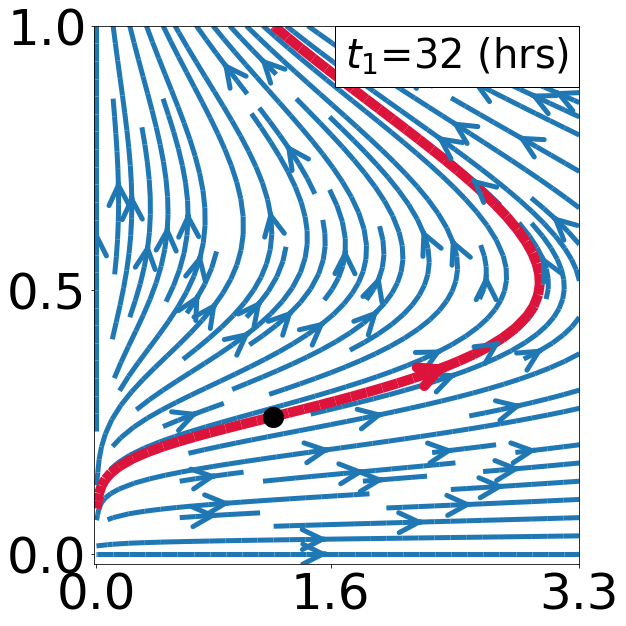

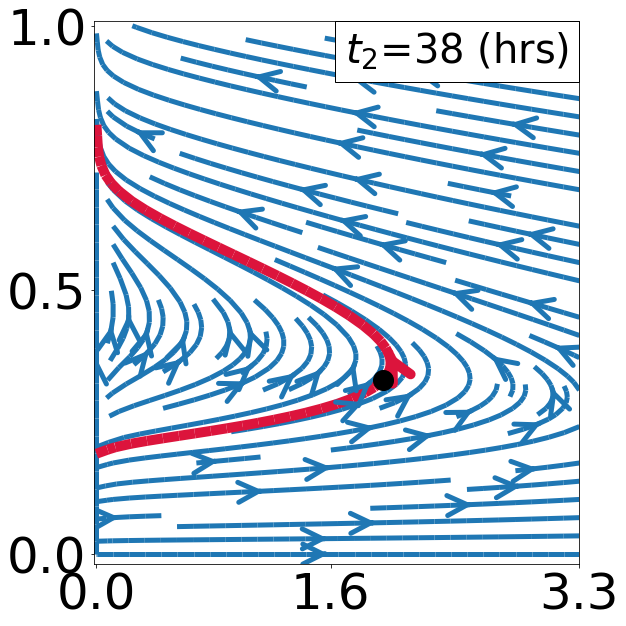

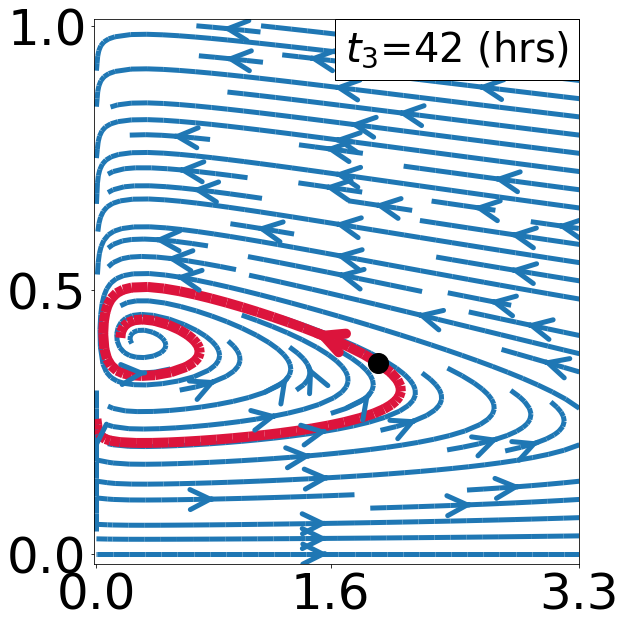

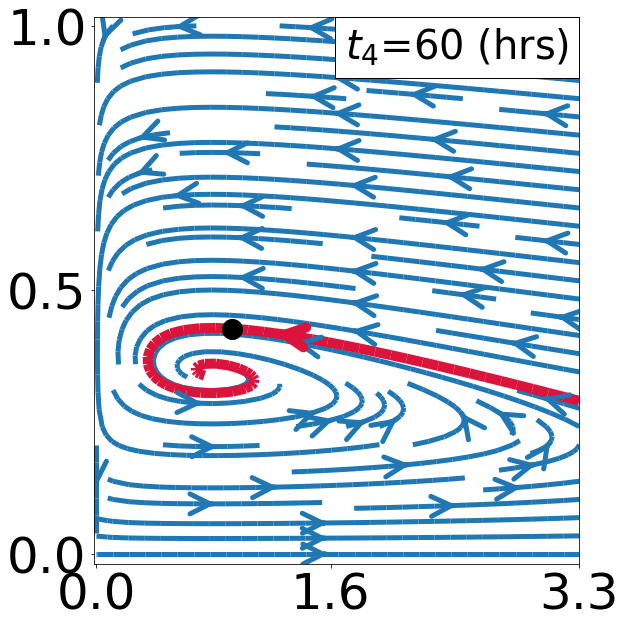

In [141]:
## Looping through values found and saving as figures.
xvalues, yvalues = meshgrid(np.linspace(0,3.3,num = 400), np.linspace(0., 1, num = 400))
count = 0
subset = [1,2,3,4]
for i in [2,20,32,85]:
#for i in [5,67,78,98,109,140,296]:
    plt.rcParams.update({'font.size': 50})
    xdot, ydot = ode(t[i], xvalues, yvalues, model_params)
    start = [prediction[i,:]]
    time = t[i]

    fig, ax = plt.subplots(figsize = (10,10))
    ax.streamplot(xvalues, yvalues, xdot, ydot, linewidth = 5, 
                  arrowsize = 5, arrowstyle = '->')
    ax.streamplot(xvalues, yvalues, xdot, ydot, start_points = start, 
                  linewidth = 10,color = 'crimson', arrowsize = 5, arrowstyle = '->')
    ax.plot(*start[0], marker = 'o', color = 'k', markersize = 20)
#    plt.xlabel('Tumor Cell Population (CI)')
#    plt.ylabel('CAR T-cell population (CI)')
    plt.xlabel('')
    plt.ylabel('')
#    plt.title('t = %2.2f hrs' % time, size = 40)
    anchored_text = AnchoredText(r'$t_%i$=%2.0f (hrs)' % (subset[count], time), loc = 1, 
                                 borderpad = 0, pad = 0.25, prop=dict(size=40))
    ax.add_artist(anchored_text)
    count = count+1

    ax.set_xticks([0,1.6,3.3])
    ax.set_yticks([0,0.5,1])
    ax.margins(x=0,y=0)
#    plt.xticks(fontsize = 40)
#    plt.yticks(fontsize = 40)
    plt.tight_layout()
    plt.savefig('/Users/abrummer/Desktop/streamplot_pbt128+_carthigh_dex1e07_time'+str(round(time,1))+'.png', 
                dpi = 300)
    plt.show()